In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(cowplot)
library(aplot)
library(ggtree)
})
theme_set(theme_cowplot())
options(repr.plot.width=15,repr.plot.height=9)

# Clustered Heatmap

There are many packages that generate clustered heatmaps on ggplot2, but none of them are composable.

This notebook illustrates how to make a clustered heatmap in a composable way, using the [aplot](https://yulab-smu.top/pkgdocs/aplot.html) package.

## code

In [2]:
insert_generic <- function(data, plot, side, size=1) {
    if(side == 'top') {
        insert_top(data, plot, height=size)
    } else if(side == 'bottom') {
        insert_bottom(data, plot, height=size)
    } else if(side == 'left') {
        insert_left(data, plot, width=size)
    } else if(side == 'right') {
        insert_right(data, plot, width=size)
    } else {
        stop('unknown side')
    }
}

In [3]:
insert_hclust <- function(ggp,
                          cluster_by,
                          side=c('top','left'),
                          dist_method="euclidean",
                          hclust_method='complete',
                          size=0.1) {

    plot <- ggp
    if('aplot' %in% class(ggp)) {
        ggp <- plot$plotlist[[1]]
    }

    mdata <-
        ggp$data |>
        mutate(!!!ggp$mapping) |>
        pivot_wider(names_from = 'x', values_from = {{cluster_by}}, id_cols=y) |>
        column_to_rownames('y') |>
        as.matrix()

    reduce(side, function(p, s) {
        if(s %in% c('left','right')) {
            dd <-
            mdata |>
            dist(method=dist_method) |>
            hclust(method=hclust_method) |>
            ggtree(branch.length='none')
            if(s == 'right') { dd <- dd + scale_x_reverse() }
            p <- insert_generic(p, dd, side=s, size=size)
        }
        if(s %in% c('top','bottom')) {
            dd <-
            t(mdata) |>
            dist(method=dist_method) |>
            hclust(method=hclust_method) |>
            ggtree(branch.length='none')
            if(s == 'bottom') { dd <- dd + coord_flip() }
            else { dd <- dd + layout_dendrogram() }
            p <- insert_generic(p, dd, side=s, size=size)
        }
        return(p)
    }, .init=plot)
}

In [4]:
insert_annot <- function(ggp, side, var, size=0.02, ggextra=NULL) {
    plot <- ggp
    if('aplot' %in% class(ggp)) {
        ggp <- plot$plotlist[[1]]
    }

    rem_axis <- list(coord_cartesian(expand=0) , theme(
        line=element_blank(),
        rect=element_blank(),
        axis.text=element_blank(),
        axis.title = element_blank(),
        plot.margin = margin(t = 0, r = 0,b = 0,l = 0)
    ))

    if(side %in% c('top','bottom')) {
        p <- 
            ggplot(ggp$data, aes(x=!!ggp$mapping$x, y=1, fill={{var}})) + 
            geom_tile() + rem_axis + ggextra
    }
    if(side %in% c('left','right')) {
        p <- 
            ggplot(ggp$data, aes(y=!!ggp$mapping$y, x=1, fill={{var}})) + 
            geom_tile() + rem_axis + ggextra
    }
    insert_generic(data=plot, plot=p, side=side, size=size)
}

# Basic Heatmap

In [11]:
data <-
    rownames_to_column(mtcars, 'model') |>
    pivot_longer(names_to = 'var', values_to = 'value', -model) |>
    mutate(scaled.val = scale(value), .by=var)
head(data, 3)

model,var,value,scaled.val
<chr>,<chr>,<dbl>,"<dbl[,1]>"
Mazda RX4,mpg,21,0.150884824647657
Mazda RX4,cyl,6,-0.104987808575239
Mazda RX4,disp,160,-0.570619818667904


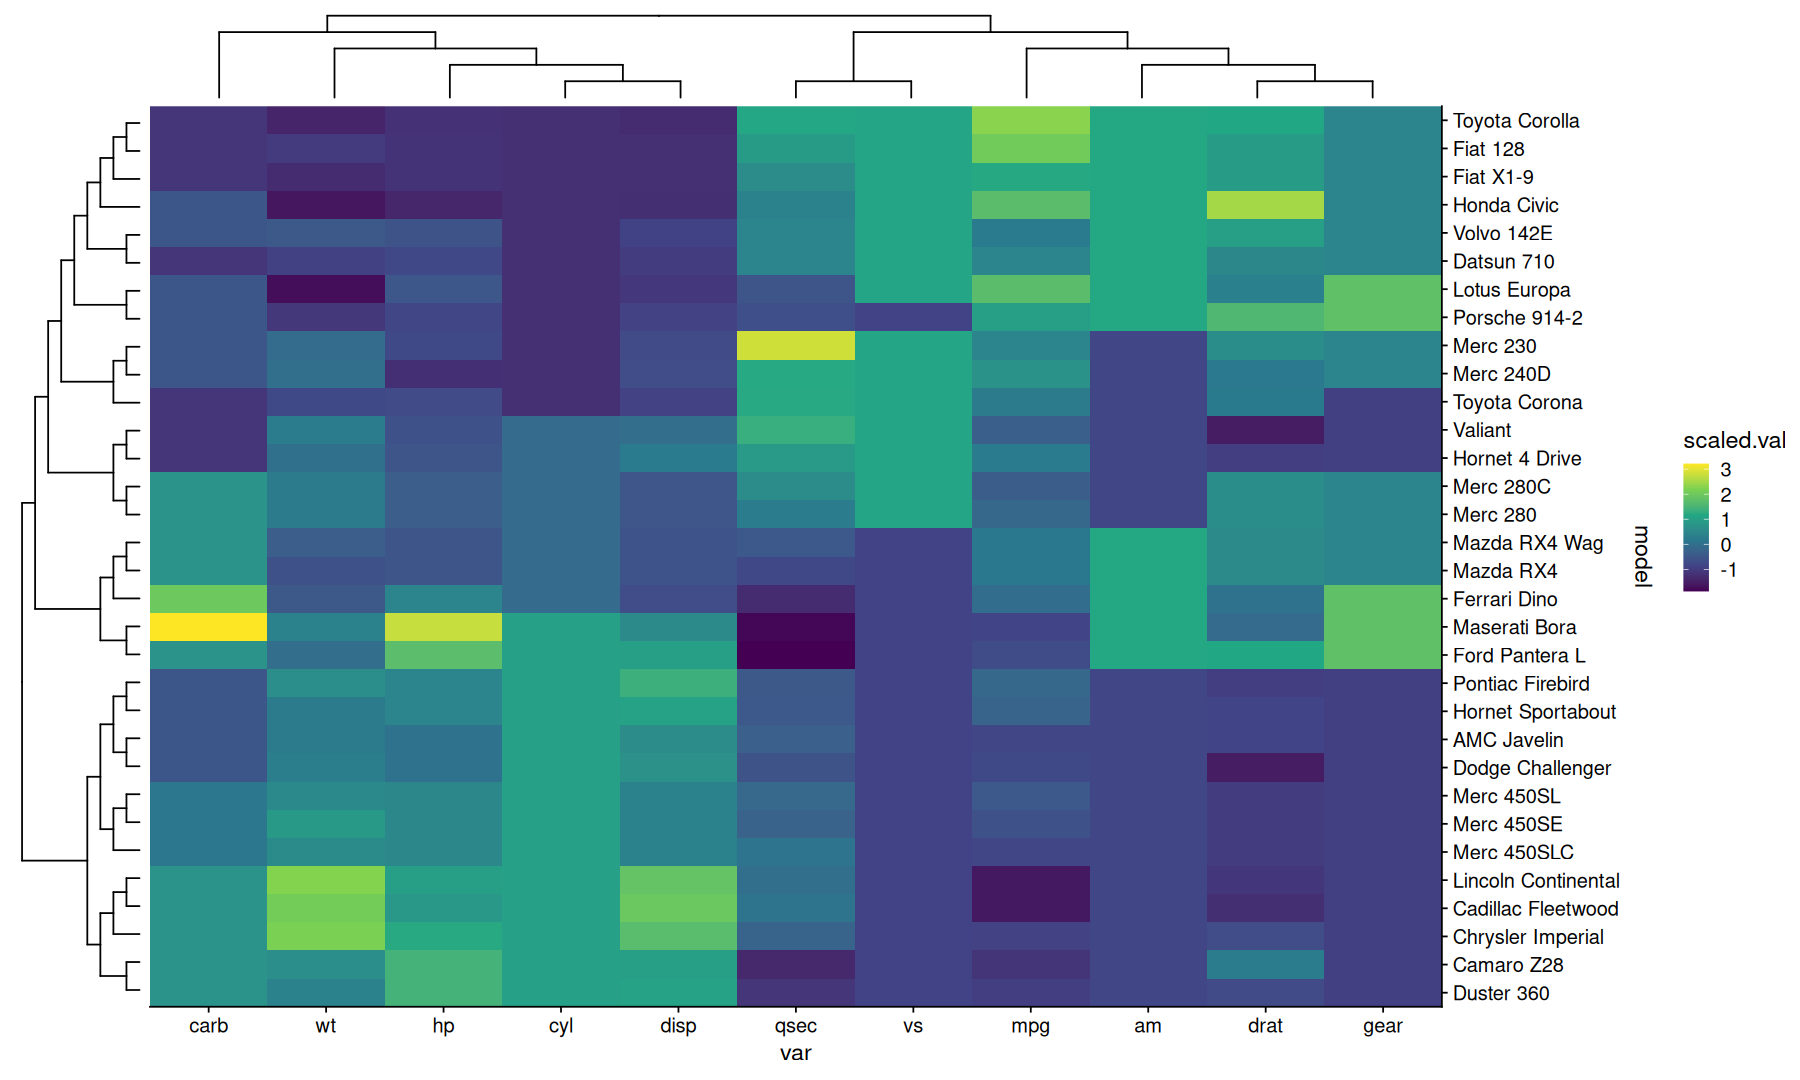

In [12]:
(
    data |>
    ggplot(aes(y=model, x=var, fill=scaled.val)) +
    geom_tile() +
    scale_fill_viridis_c() +
    coord_cartesian(expand=0) +
    scale_y_discrete(position='right')
) |>
insert_hclust(cluster_by = scaled.val, dist_method = 'canberra', hclust_method = 'ward.D2')

# Dendrogram on the alternate side

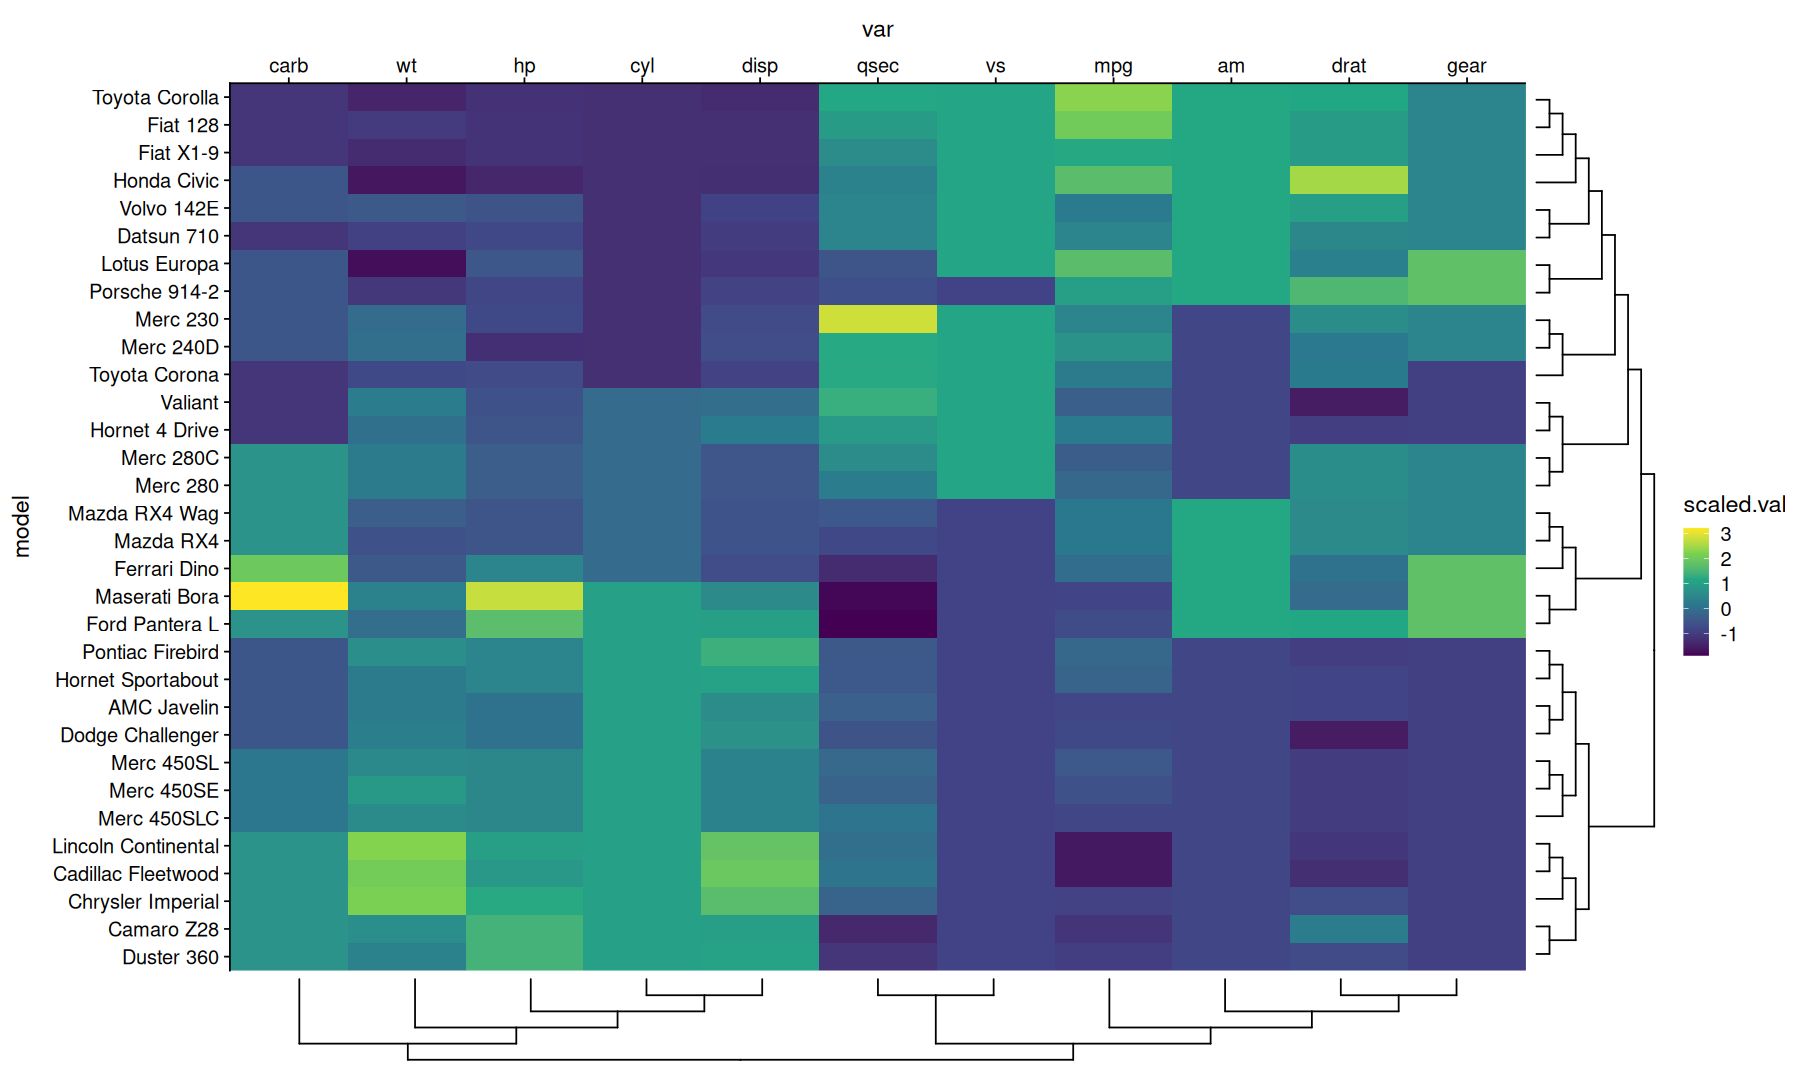

In [21]:
(
    data |>
    ggplot(aes(y=model, x=var, fill=scaled.val)) +
    geom_tile() +
    scale_fill_viridis_c() +
    coord_cartesian(expand=0) +
    scale_x_discrete(position='top')
) |>
insert_hclust(cluster_by = scaled.val, side=c('right','bottom'), dist_method = 'canberra', hclust_method = 'ward.D2')

# Heatmap with annotations

In [22]:
data <-
    dist(mtcars, method='canberra') |>
    as.matrix() |>
    as.data.frame.table(responseName='canberra.dist') |>
    inner_join(rownames_to_column(mtcars,'model'), by=c('Var1'='model'))
head(data, 3)

,Var1,Var2,canberra.dist,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Mazda RX4,Mazda RX4,0.0000000000000000,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
2,Mazda RX4 Wag,Mazda RX4,0.0694454500289716,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
3,Datsun 710,Mazda RX4,2.2473559008738091,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1


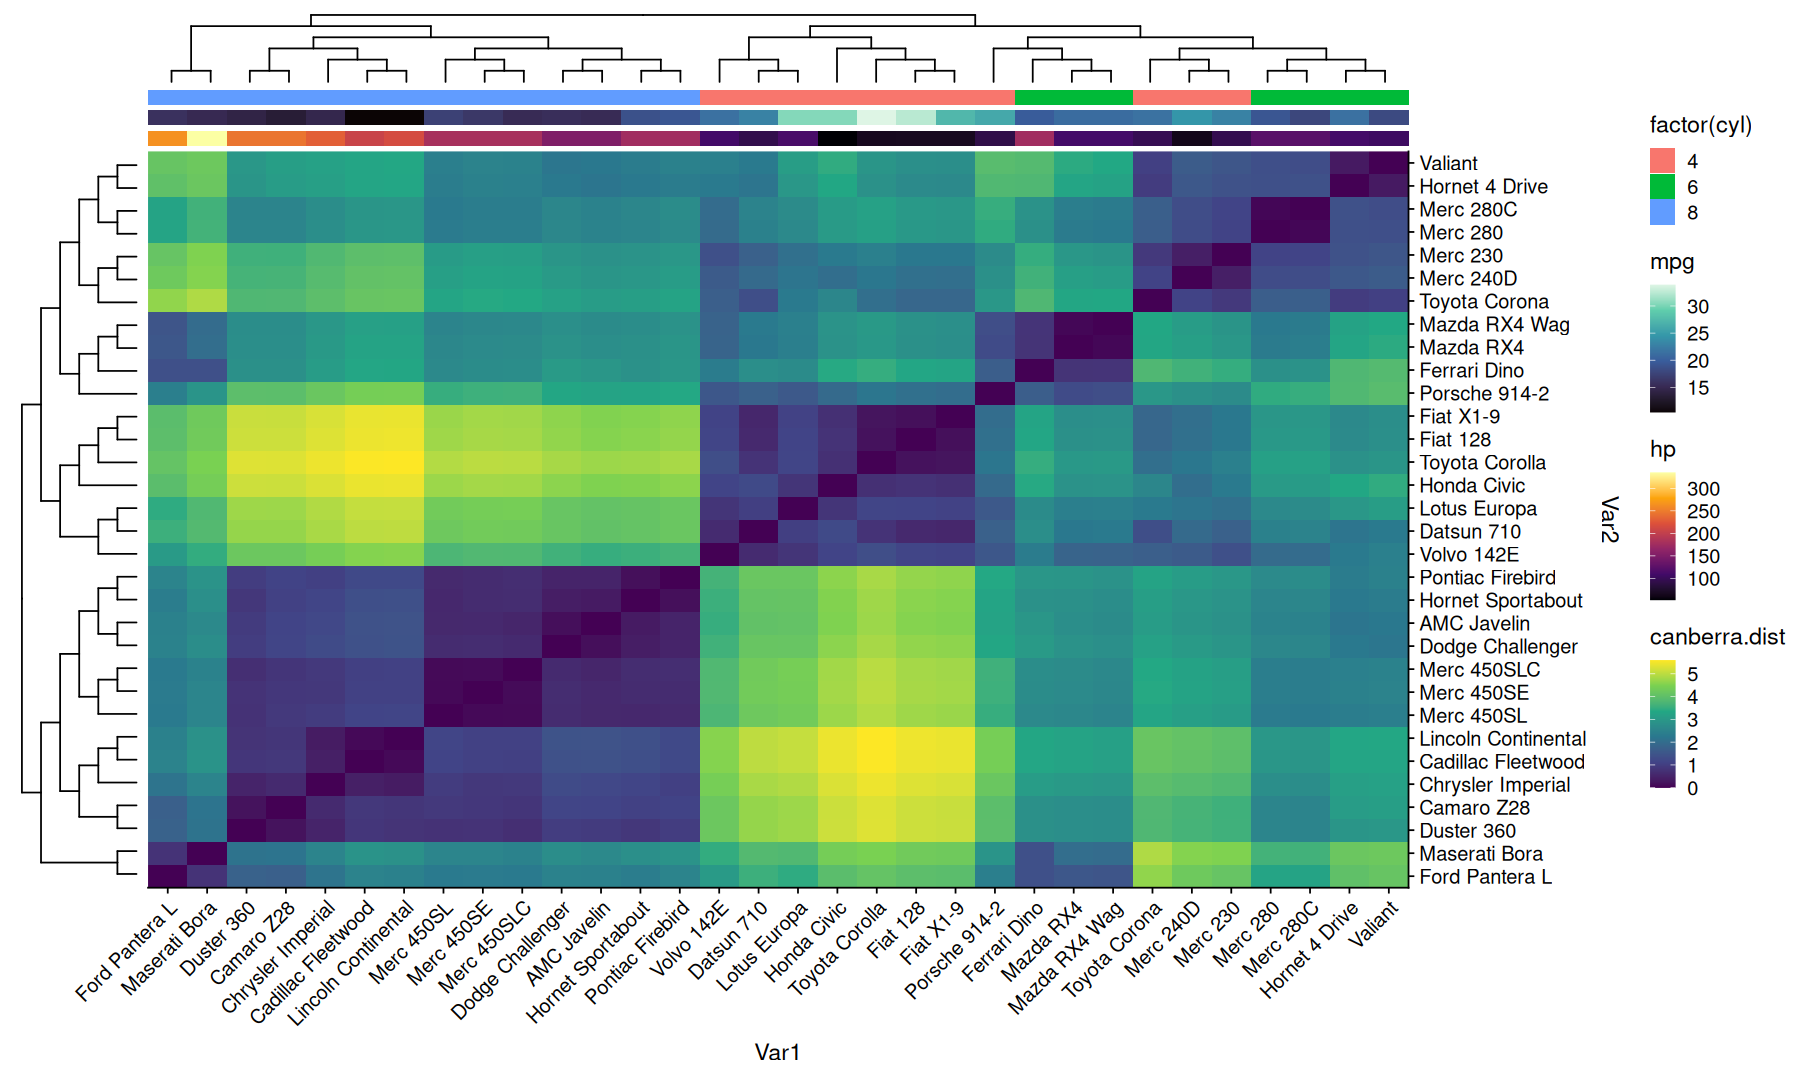

In [28]:
(
    data |>
    ggplot(aes(x=Var1, y=Var2, fill=canberra.dist)) +
    geom_tile() +
    coord_cartesian(expand=0) +
    scale_y_discrete(position='right') +
    theme(axis.text.x=element_text(angle=45,vjust=1,hjust=1)) +
    scale_fill_viridis_c()
) |>
insert_annot(side = 'top', var = hp, ggextra=scale_fill_viridis_c(option='inferno')) |>
insert_annot(side = 'top', var = mpg, ggextra=scale_fill_viridis_c(option='mako')) |>
insert_annot(side = 'top', var = factor(cyl)) |>
insert_hclust(cluster_by=canberra.dist)

# scRNA Heatmap

In [29]:
data <-
    read_tsv(system.file("extdata", "scRNA_dotplot_data.tsv.gz", package="aplot"), col_types='') |>
    mutate(expr_perc = 100 * cell_exp_ct/cell_ct) |>
    mutate(gene_mean=mean(count), .by=Gene)
head(data,3)

Gene,cluster,cell_ct,cell_exp_ct,count,Group,expr_perc,gene_mean
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
MICA,c00,4178,910,0.2890587840294733,Neuron,21.78075634274773,0.0840202740097265
MICA,c01,3532,82,0.0232163080407701,Microglia,2.32163080407701,0.0840202740097265
MICA,c02,3320,117,0.0354171573797353,Fibroblast,3.52409638554217,0.0840202740097265


Warning message:
"Removed 193 rows containing missing values or values outside the scale range (`geom_point()`)."


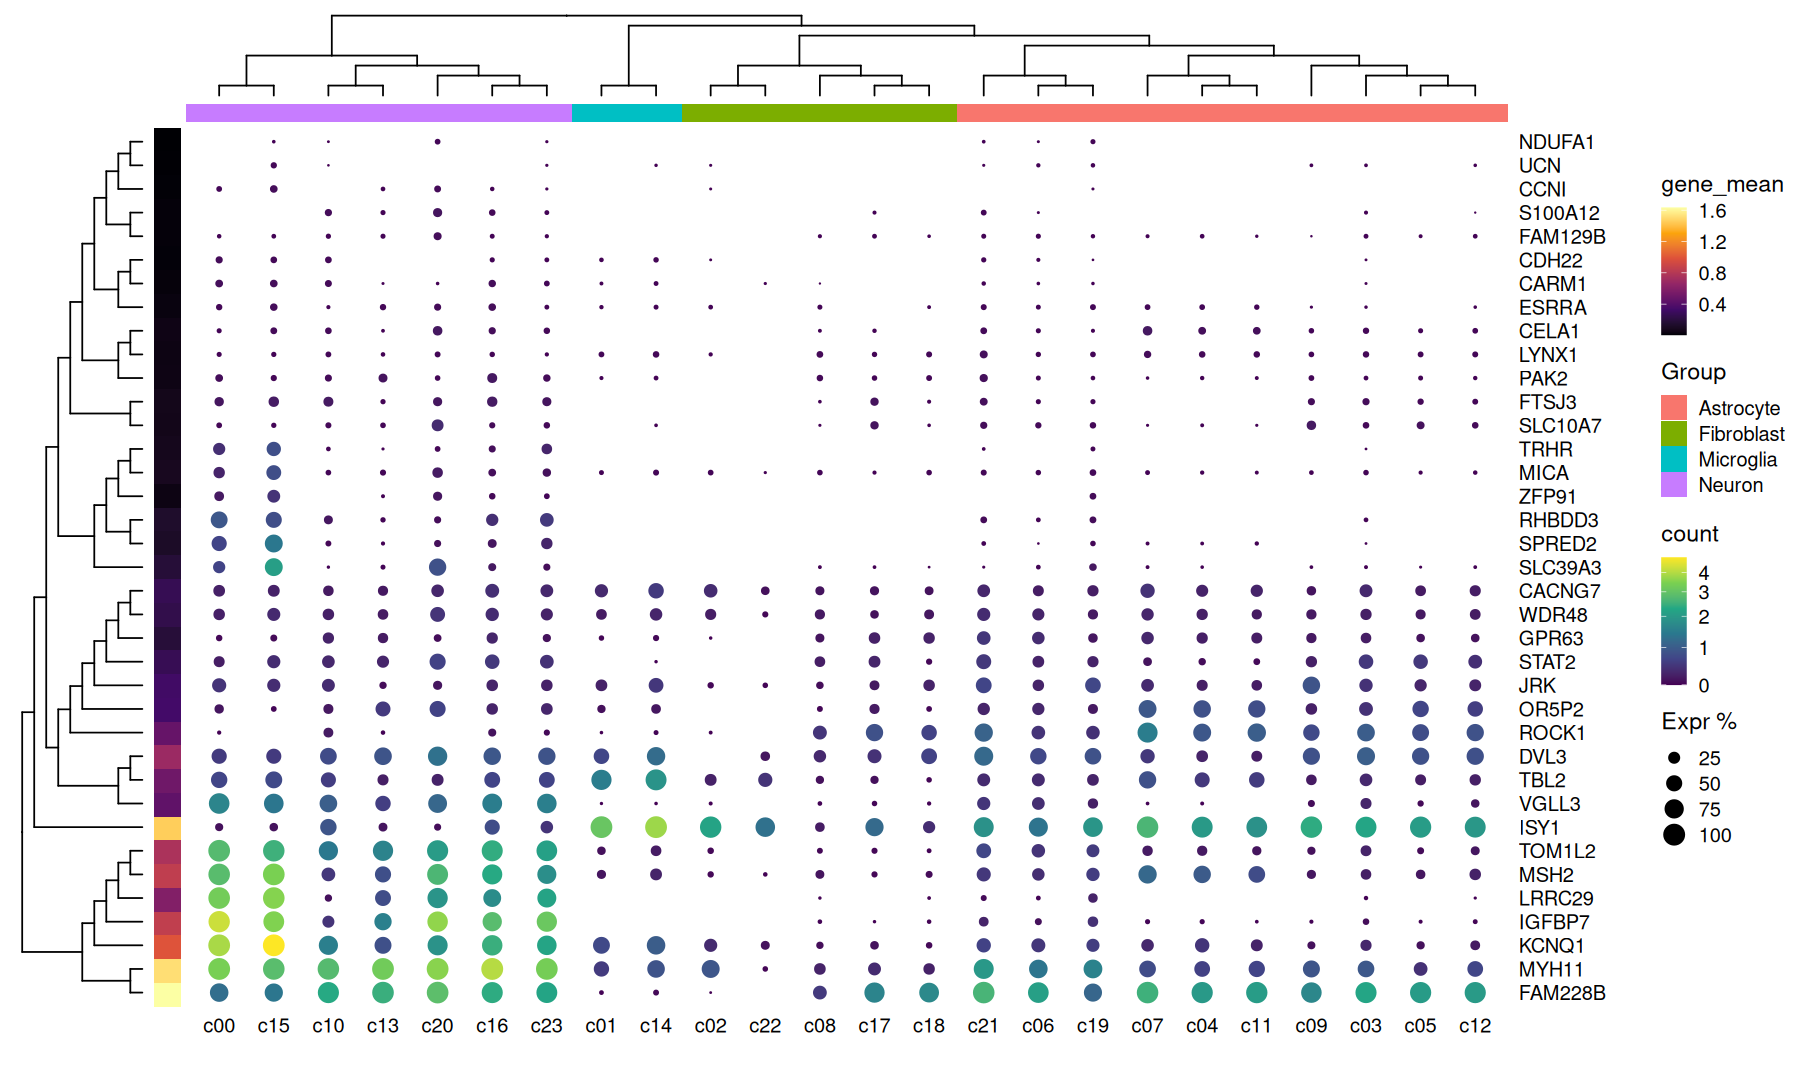

In [47]:
(
    data |>
    ggplot(aes(y=Gene, x=cluster, color=count, size=expr_perc)) +
    geom_point() +
    scale_size(limits=c(0.5, NA), range=c(0,5.5)) +
    scale_color_viridis_c(trans='pseudo_log') +
    scale_y_discrete(position = 'right') +
    theme(axis.ticks = element_blank(),axis.line = element_blank()) +
    labs(size='Expr %', x='', y='')
) |>
insert_annot(side='top', var=Group) |>
insert_annot(side='left', var=gene_mean, ggextra=scale_fill_viridis_c(option = 'inferno')) |>
insert_hclust(cluster_by=count, hclust_method='ward.D2')